In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fftfreq, rfftfreq
from scipy.fft import rfft, irfft
# from scipy.fft import dct as rfft
# from scipy.fft import idct as irfft

import sys
sys.path.append('..')
import QLCstuff2 as QLC_nonDim
import QLCstuff as QLC_normal
import f90nml

In [2]:
%matplotlib ipympl
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

In [3]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
#D *= 5
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
#nu_kin *= 10
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
#tau_eq *= 10
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [4]:
#define nondimensional scalars

t_0 = tau_eq
x_0 = np.sqrt(D * tau_eq)

In [5]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

In [6]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = (x_QLC[1]-x_QLC[0])
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


In [7]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime = 10 ##################################### 4ms run time  any greater creates instabilities
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC_nonDim.getNQLL(Ntot_init_1D,Nstar,Nbar) #same function in both dimesnional and non dimensional

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 10 millisecond
This is a run from time 0.0 millisecond to 10.0 millisecond
dt = 204.08163265306123 microsecond


In [8]:
Ntotkeep_1D_nondimensional, NQLLkeep_1D_nondimensional = QLC_nonDim.run_f1d_dimensionless(\
    NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
    Nbar, 
    Nstar, 
    sigma0.magnitude, 
    nu_kin_mlyperus.magnitude,
    deltax.magnitude,
    D.magnitude,
    tau_eq.magnitude, 
    sigmaI_QLC,\
    AssignQuantity,\
    verbose=0, odemethod='RK45')
Nicekeep_1D_nondimensional = Ntotkeep_1D_nondimensional-NQLLkeep_1D_nondimensional

10 % elapsed time is 0.004 minutes
20 % elapsed time is 0.007 minutes
30 % elapsed time is 0.011 minutes
40 % elapsed time is 0.014 minutes
50 % elapsed time is 0.018 minutes
60 % elapsed time is 0.022 minutes
70 % elapsed time is 0.026 minutes
80 % elapsed time is 0.029 minutes
90 % elapsed time is 0.033 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


In [9]:
Ntotkeep_1D_cart, NQLLkeep_1D_cart = QLC_normal.run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_cart = Ntotkeep_1D_cart - NQLLkeep_1D_cart

10 % elapsed time is 0.012 minutes
20 % elapsed time is 0.015 minutes
30 % elapsed time is 0.019 minutes
40 % elapsed time is 0.022 minutes
50 % elapsed time is 0.026 minutes
60 % elapsed time is 0.030 minutes
70 % elapsed time is 0.033 minutes
80 % elapsed time is 0.037 minutes
90 % elapsed time is 0.041 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


In [10]:
DoverL2pi2 = D/L**2*np.pi**2

Ntotkeep_1D_FT, NQLLkeep_1D_FT = QLC_normal.run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

10 % elapsed time is 0.008 minutes
20 % elapsed time is 0.014 minutes
30 % elapsed time is 0.022 minutes
40 % elapsed time is 0.030 minutes
50 % elapsed time is 0.038 minutes
60 % elapsed time is 0.045 minutes
70 % elapsed time is 0.054 minutes
80 % elapsed time is 0.063 minutes
90 % elapsed time is 0.071 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


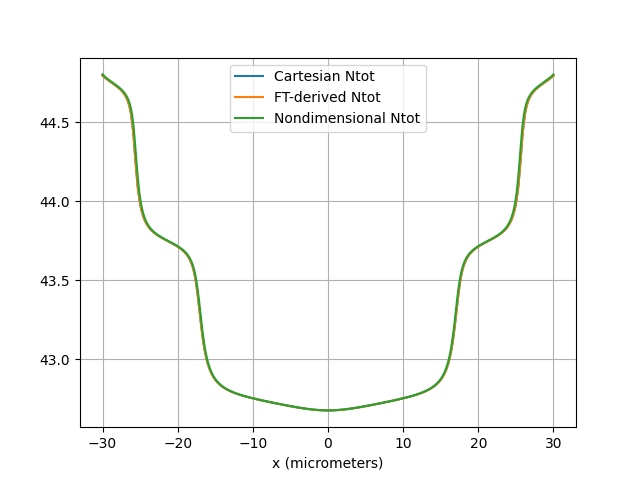

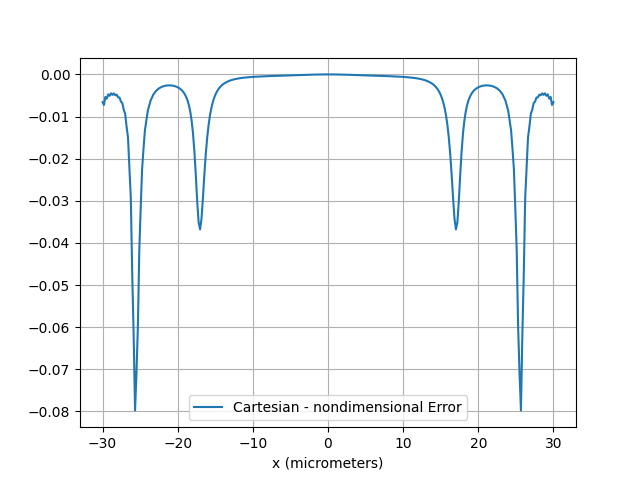

In [11]:
plt.figure()
plt.plot(x_QLC.magnitude,Ntotkeep_1D_cart[-1],label='Cartesian Ntot')
plt.plot(x_QLC.magnitude,Ntotkeep_1D_FT[-1],label='FT-derived Ntot')
plt.plot(x_QLC.magnitude,Ntotkeep_1D_nondimensional[-1],label='Nondimensional Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(x_QLC.magnitude,(Ntotkeep_1D_cart[-1] - Ntotkeep_1D_nondimensional[-1]),label='Cartesian - nondimensional Error')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()

In [12]:
def get_runs(sigmaI_corner_s = 1, sigma0_s = 1, c_r_s = 1, Nbar_s = 1, Nstar_s = 1,
             h_pr_s = 1, D_s = 1, nu_kin_s = 1, L_s = 1, nx_crystal_s = 1, tau_eq_s = 1,
             runtime = 50, times = 50, FT = False):
    inputfile = "GI parameters - Reference limit cycle (for testing).nml"

    # For readability ...
    print('Using parameter file '+inputfile+' ...')

    print('\nFrom the GrowthInstability (GI) namelist:')
    GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

    # Supersaturation at the corner of a facet
    sigmaI_corner = GI['sigmaI_corner'] * sigmaI_corner_s
    sigmaI_corner_units = GI['sigmaI_corner_units']
    sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
    print('sigmaI_corner =', sigmaI_corner)

    # Difference in equilibrium supersaturation between microsurfaces I and II
    sigma0 = GI['sigma0'] * sigma0_s
    sigma0_units = GI['sigma0_units']
    sigma0 = AssignQuantity(sigma0,sigma0_units)
    print('sigma0 =',sigma0)

    # Reduction of supersaturation at the facet cental
    c_r = GI['c_r'] * c_r_s
    c_r_units = GI['c_r_units']
    c_r = AssignQuantity(c_r,c_r_units)
    print('c_r =',c_r)

    # Properties of the QLL
    Nbar = GI['Nbar'] * Nbar_s; print('Nbar', Nbar) 
    Nstar = GI['Nstar'] * Nstar_s; print('Nstar', Nstar)

    # Thickness of monolayers
    h_pr = GI['h_pr'] * h_pr_s
    h_pr_units = GI['h_pr_units']
    h_pr = AssignQuantity(h_pr,h_pr_units) 
    print('h_pr =', h_pr)

    # Diffusion coeficient
    D = GI['D'] * D_s
    D_units = GI['D_units']
    D = AssignQuantity(D,D_units)
    print('D =', D)

    # Deposition velocity
    nu_kin = GI['nu_kin'] * nu_kin_s
    nu_kin_units = GI['nu_kin_units']
    nu_kin = AssignQuantity(nu_kin,nu_kin_units)
    print('nu_kin =', nu_kin)

    # Size of the facet
    L = GI['L'] * L_s
    L_units = GI['L_units']
    L = AssignQuantity(L,L_units)
    print('L =', L)

    # Crystal size -- needs to be an even number
    nx_crystal = GI['nx_crystal'] * nx_crystal_s
    print('nx (crystal) =', nx_crystal)

    # Time constant for freezing/thawing
    tau_eq = GI['tau_eq'] * tau_eq_s
    #tau_eq *= 10
    tau_eq_units = GI['tau_eq_units']
    tau_eq = AssignQuantity(tau_eq,tau_eq_units)
    print('tau_eq =',tau_eq)

    # Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
    odemethod = GI['odemethod']
    print('odemethod =',odemethod)

    #define nondimensional scalars

    t_0 = tau_eq
    x_0 = np.sqrt(D * tau_eq)

    # Conversions (in case inputs are in other units)
    sigma0.ito('dimensionless')
    h_pr.ito('micrometer')
    D.ito('micrometer^2/microsecond')
    nu_kin.ito('micrometer/second')
    L.ito('micrometer')
    sigmaI_corner.ito('dimensionless')
    c_r.ito('dimensionless')
    tau_eq.ito('microsecond')
    
    x_QLC = np.linspace(-L,L,nx_crystal)
    deltax = (x_QLC[1]-x_QLC[0])
    print('Spacing of points on the ice surface =', deltax)
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
    nu_kin_mlyperus = nu_kin/h_pr
    nu_kin_mlyperus.ito('1/microsecond')
    Doverdeltax2 = D/deltax**2

    RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

    # How long
    runtime_units = RT['runtime_units']
    runtime = AssignQuantity(runtime,runtime_units)
    print('runtime =', runtime)
    runtime.ito('microsecond')

    # Number of time steps to keep for reporting later
    ntimes = times

    # Flag if we want more output
    verbose = RT['verbose']

    # Specify the time interval and initial conditions
    tkeep_1Darr = np.linspace(0,runtime,ntimes)
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC_nonDim.getNQLL(Ntot_init_1D,Nstar,Nbar) #same function in both dimesnional and non dimensional

    print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
    print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    Ntotkeep_1D_nondimensional, NQLLkeep_1D_nondimensional = QLC_nonDim.run_f1d_dimensionless(\
        NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
        Nbar, 
        Nstar, 
        sigma0.magnitude, 
        nu_kin_mlyperus.magnitude,
        deltax.magnitude,
        D.magnitude,
        tau_eq.magnitude, 
        sigmaI_QLC,\
        AssignQuantity,\
        verbose=0, odemethod='RK45')
    Nicekeep_1D_nondimensional = Ntotkeep_1D_nondimensional-NQLLkeep_1D_nondimensional

    Ntotkeep_1D_cart, NQLLkeep_1D_cart = QLC_normal.run_f1d(\
        NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
        Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
        AssignQuantity,\
        verbose=0, odemethod='RK45')
    Nicekeep_1D_cart = Ntotkeep_1D_cart - NQLLkeep_1D_cart

    if(FT):
        DoverL2pi2 = D/L**2*np.pi**2

        Ntotkeep_1D_FT, NQLLkeep_1D_FT = QLC_normal.run_f1d_FT(\
            NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
            Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
            AssignQuantity,\
            verbose=0, odemethod='RK45')
        Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

    val = [np.array([Ntotkeep_1D_cart, NQLLkeep_1D_cart, Nicekeep_1D_cart]), 
            np.array([Ntotkeep_1D_nondimensional, NQLLkeep_1D_nondimensional, Nicekeep_1D_nondimensional])]
    if(FT):
        val += np.array([Ntotkeep_1D_FT, NQLLkeep_1D_FT, Nicekeep_1D_FT]), 
    
    return val

In [13]:
def plot_together(list1, list2, xlist, label1 = "", label2 = ""):
    plt.figure()
    plt.plot(xlist,list1,label=label1)
    plt.plot(xlist,list2,label=label2)
    plt.xlabel('x (micrometers)')
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(xlist,(list1 - list2),label='Error')
    plt.xlabel('x (micrometers)')
    plt.grid(True)
    plt.legend()

In [14]:
val1 = get_runs(runtime=50)
val2 = get_runs(D_s = 0.75, runtime=50)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45
Spacing of points on the ice surface = 0.18808777429467227 micrometer
runtime = 50 millisecond
This is a run from time 0.0 millisecond to 50.0 millisecond
dt = 1020.4081632653061 microsecond
10 % elapsed time is 0.020 minutes
20 % elapsed time is 0.039 minutes
30 % elapsed time is 0.057 minutes
40 % elapsed time is 0.075 minutes
50 % elapsed time is 0.094 minutes
60 % elapsed time is 0.111 minutes
70 % elapsed time is 0.130 minutes
80 % elapsed time is 0.148 minutes
90 % elapsed time is 0.167 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integratio

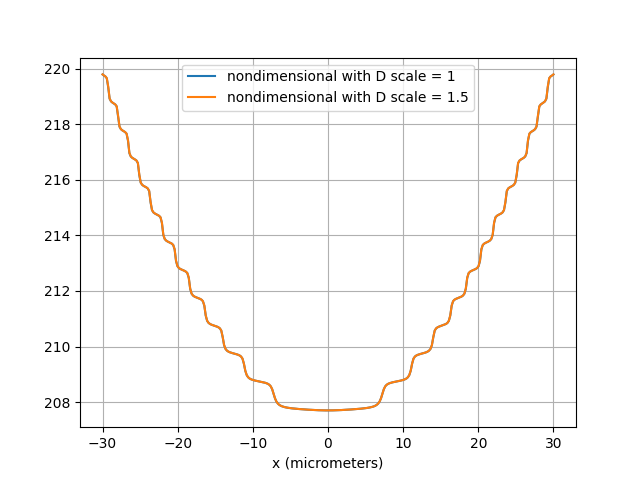

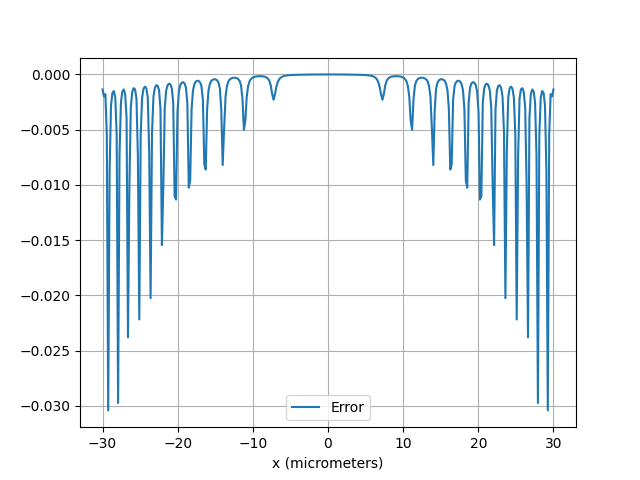

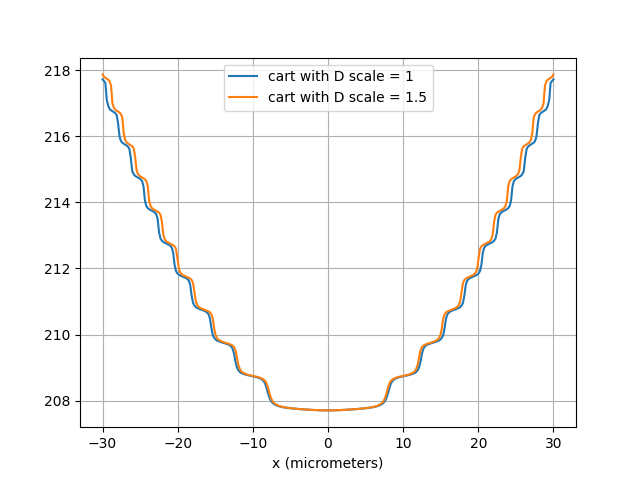

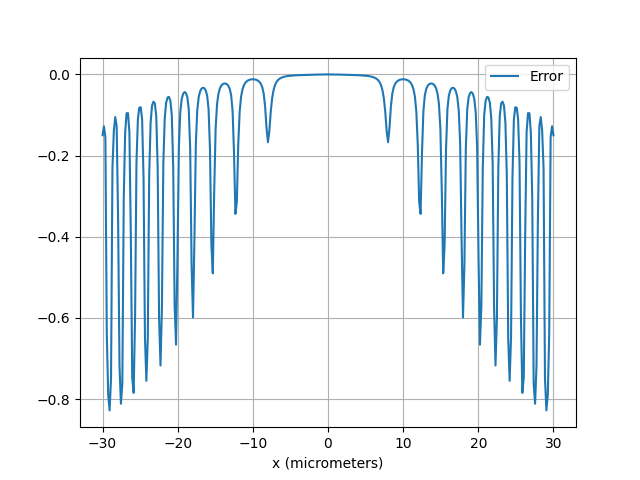

In [15]:
plot_together(val1[-1][0][-1], val2[-1][0][-1], x_QLC.magnitude, "nondimensional with D scale = 1", "nondimensional with D scale = 1.5")
plot_together(val1[0][0][-1], val2[0][0][-1], x_QLC.magnitude, "cart with D scale = 1", "cart with D scale = 1.5")

In [16]:
x_QLC/L

array([-1.        , -0.99373041, -0.98746082, -0.98119122, -0.97492163,
       -0.96865204, -0.96238245, -0.95611285, -0.94984326, -0.94357367,
       -0.93730408, -0.93103448, -0.92476489, -0.9184953 , -0.91222571,
       -0.90595611, -0.89968652, -0.89341693, -0.88714734, -0.88087774,
       -0.87460815, -0.86833856, -0.86206897, -0.85579937, -0.84952978,
       -0.84326019, -0.8369906 , -0.830721  , -0.82445141, -0.81818182,
       -0.81191223, -0.80564263, -0.79937304, -0.79310345, -0.78683386,
       -0.78056426, -0.77429467, -0.76802508, -0.76175549, -0.75548589,
       -0.7492163 , -0.74294671, -0.73667712, -0.73040752, -0.72413793,
       -0.71786834, -0.71159875, -0.70532915, -0.69905956, -0.69278997,
       -0.68652038, -0.68025078, -0.67398119, -0.6677116 , -0.66144201,
       -0.65517241, -0.64890282, -0.64263323, -0.63636364, -0.63009404,
       -0.62382445, -0.61755486, -0.61128527, -0.60501567, -0.59874608,
       -0.59247649, -0.5862069 , -0.5799373 , -0.57366771, -0.56739812,
       -0.56112853, -0.55485893, -0.54858934, -0.54231975, -0.53605016,
       -0.52978056, -0.52351097, -0.51724138, -0.51097179, -0.50470219,
       -0.4984326 , -0.49216301, -0.48589342, -0.47962382, -0.47335423,
       -0.46708464, -0.46081505, -0.45454545, -0.44827586, -0.44200627,
       -0.43573668, -0.42946708, -0.42319749, -0.4169279 , -0.41065831,
       -0.40438871, -0.39811912, -0.39184953, -0.38557994, -0.37931034,
       -0.37304075, -0.36677116, -0.36050157, -0.35423197, -0.34796238,
       -0.34169279, -0.3354232 , -0.32915361, -0.32288401, -0.31661442,
       -0.31034483, -0.30407524, -0.29780564, -0.29153605, -0.28526646,
       -0.27899687, -0.27272727, -0.26645768, -0.26018809, -0.2539185 ,
       -0.2476489 , -0.24137931, -0.23510972, -0.22884013, -0.22257053,
       -0.21630094, -0.21003135, -0.20376176, -0.19749216, -0.19122257,
       -0.18495298, -0.17868339, -0.17241379, -0.1661442 , -0.15987461,
       -0.15360502, -0.14733542, -0.14106583, -0.13479624, -0.12852665,
       -0.12225705, -0.11598746, -0.10971787, -0.10344828, -0.09717868,
       -0.09090909, -0.0846395 , -0.07836991, -0.07210031, -0.06583072,
       -0.05956113, -0.05329154, -0.04702194, -0.04075235, -0.03448276,
       -0.02821317, -0.02194357, -0.01567398, -0.00940439, -0.0031348 ,
        0.0031348 ,  0.00940439,  0.01567398,  0.02194357,  0.02821317,
        0.03448276,  0.04075235,  0.04702194,  0.05329154,  0.05956113,
        0.06583072,  0.07210031,  0.07836991,  0.0846395 ,  0.09090909,
        0.09717868,  0.10344828,  0.10971787,  0.11598746,  0.12225705,
        0.12852665,  0.13479624,  0.14106583,  0.14733542,  0.15360502,
        0.15987461,  0.1661442 ,  0.17241379,  0.17868339,  0.18495298,
        0.19122257,  0.19749216,  0.20376176,  0.21003135,  0.21630094,
        0.22257053,  0.22884013,  0.23510972,  0.24137931,  0.2476489 ,
        0.2539185 ,  0.26018809,  0.26645768,  0.27272727,  0.27899687,
        0.28526646,  0.29153605,  0.29780564,  0.30407524,  0.31034483,
        0.31661442,  0.32288401,  0.32915361,  0.3354232 ,  0.34169279,
        0.34796238,  0.35423197,  0.36050157,  0.36677116,  0.37304075,
        0.37931034,  0.38557994,  0.39184953,  0.39811912,  0.40438871,
        0.41065831,  0.4169279 ,  0.42319749,  0.42946708,  0.43573668,
        0.44200627,  0.44827586,  0.45454545,  0.46081505,  0.46708464,
        0.47335423,  0.47962382,  0.48589342,  0.49216301,  0.4984326 ,
        0.50470219,  0.51097179,  0.51724138,  0.52351097,  0.52978056,
        0.53605016,  0.54231975,  0.54858934,  0.55485893,  0.56112853,
        0.56739812,  0.57366771,  0.5799373 ,  0.5862069 ,  0.59247649,
        0.59874608,  0.60501567,  0.61128527,  0.61755486,  0.62382445,
        0.63009404,  0.63636364,  0.64263323,  0.64890282,  0.65517241,
        0.66144201,  0.6677116 ,  0.67398119,  0.68025078,  0.68652038,
        0.69278997,  0.69905956,  0.70532915,  0.71159875,  0.71786834,
        0.72413793,  0.73040752,  0.7366